# Data Structures
This is the data structures:

In [ ]:
torch.save(
            output_collections,
            f"hans-augmentation-{version}."
            f"{train_task_name}."
            f"{train_heuristic}."
            f"{num_replicas}."
            f"{use_parallel}_featSim.pth")

output_collections: Dict[str, List] = defaultdict(list)
# 10 copies of each combination
output_collections[
                    f"{experiment_type}-"
                    f"{replica_index}-"
                    f"{version_2_num_datapoints}-"
                    f"{version_2_learning_rate}-"
                ].append(outputs_one_experiment)


outputs_one_experiment = {
        # "s_test": s_test,
        "influences": influences,
        "loss": loss_collections,
        "accuracy": accuracy_collections,
        "datapoint_indices": datapoint_indices,
        "learning_rate": learning_rate,
        "num_datapoints": num_datapoints,
        "hans_eval_heuristic_inputs": hans_eval_heuristic_inputs,
    }

# Loop across ["lexical_overlap", "subsequence", "constituent"]
loss_collections = {}
accuracy_collections = {}

# Baseline accuracy and loss


In [ ]:
import transformers
from experiments.hans_utils import HansHelper
from experiments import misc_utils
from experiments import constants
from typing import Union, Dict, Any, List, Tuple, Optional
from transformers import TrainingArguments

def evaluate_heuristic(
        hans_helper: HansHelper,
        heuristic: str,
        trainer: transformers.Trainer,
        model: torch.nn.Module,
) -> Tuple[float, float]:

    _, batch_dataloader = hans_helper.get_dataset_and_dataloader_of_heuristic(
        mode="eval",
        heuristic=heuristic,
        batch_size=1000,
        random=False)

    loss = 0.
    num_corrects = 0.
    num_examples = 0
    for index, inputs in enumerate(batch_dataloader):
        batch_size = inputs["labels"].shape[0]
        batch_preds, batch_label_ids, batch_mean_loss = misc_utils.predict(
            trainer=trainer,
            model=model,
            inputs=inputs)

        num_examples += batch_size
        loss += batch_mean_loss * batch_size
        num_corrects += (batch_preds.argmax(axis=-1) == batch_label_ids).sum()

    return loss / num_examples, num_corrects / num_examples


baseline = {
    "loss":{
        "lexical_overlap":None,
        "subsequence": None,
        "constituent":None
    },
    "accuracy":{
        "lexical_overlap":None,
        "subsequence": None,
        "constituent":None
    }
}

def baseline_getter():
    task_tokenizer, task_model = misc_utils.create_tokenizer_and_model(
            constants.MNLI2_MODEL_PATH)

    trainer = transformers.Trainer(
            model=task_model,  # Thean: i.e. mnli2
            args=TrainingArguments(
                output_dir="./tmp-output",
                per_device_train_batch_size=128,
                per_device_eval_batch_size=128,
                learning_rate=5e-5,
                logging_steps=100),
    )
    
    (hans_train_dataset,
         hans_eval_dataset) = misc_utils.create_datasets(
            task_name="hans",
            tokenizer=task_tokenizer)

    hans_helper = HansHelper(
            hans_train_dataset=hans_train_dataset,
            hans_eval_dataset=hans_eval_dataset)

    for h in ["lexical_overlap", "subsequence", "constituent"]:
        new_model_loss, new_model_accuracy = evaluate_heuristic(
                hans_helper=hans_helper,
                heuristic=h,
                trainer=trainer,
                model=task_model)
        baseline["loss"][h] = new_model_loss
        baseline["accuracy"][h] = new_model_accuracy
        
    return baseline

In [39]:
baseline = baseline_getter()

Params Trainable: 14767874
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

In [4]:
'''
{'loss': {'lexical_overlap': 1.7321148809045552,
   'subsequence': 1.516138620302081,
   'constituent': 1.34275316093117},
  'accuracy': {'lexical_overlap': 0.4973,
   'subsequence': 0.5225,
   'constituent': 0.512}}
'''
baseline = {'loss': {'lexical_overlap': 1.7321148809045552,
   'subsequence': 1.516138620302081,
   'constituent': 1.34275316093117},
  'accuracy': {'lexical_overlap': 0.4973,
   'subsequence': 0.5225,
   'constituent': 0.512}}

# Helper Functions

In [1]:
def to_dict(a_dict):
    #lexical subsequence constituent
    def infl():
        return {"helpful":[[],[],[]], "harmful":[[],[],[]], "random":[[],[],[]]}

    def lsc():
        return {"lexical_overlap": infl(), 
                "subsequence": infl(), 
                "constituent":infl()}
    
    d = {"loss": lsc(), "accuracy": lsc()}

    i = 0
    for key in a_dict.keys():
        # Influence
        infl = ["helpful", "harmful", "random"][i//3]
        for statistics in range (len(a_dict[key])):
            for la in ["loss", "accuracy"]:
                dict_la = a_dict[key][statistics][la]
                d[la]["lexical_overlap"][infl][i%3].append(dict_la["lexical_overlap"])
                d[la]["subsequence"][infl][i%3].append(dict_la["subsequence"])
                d[la]["constituent"][infl][i%3].append(dict_la["constituent"])
        i+=1
    
    return d

# Comparisons

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


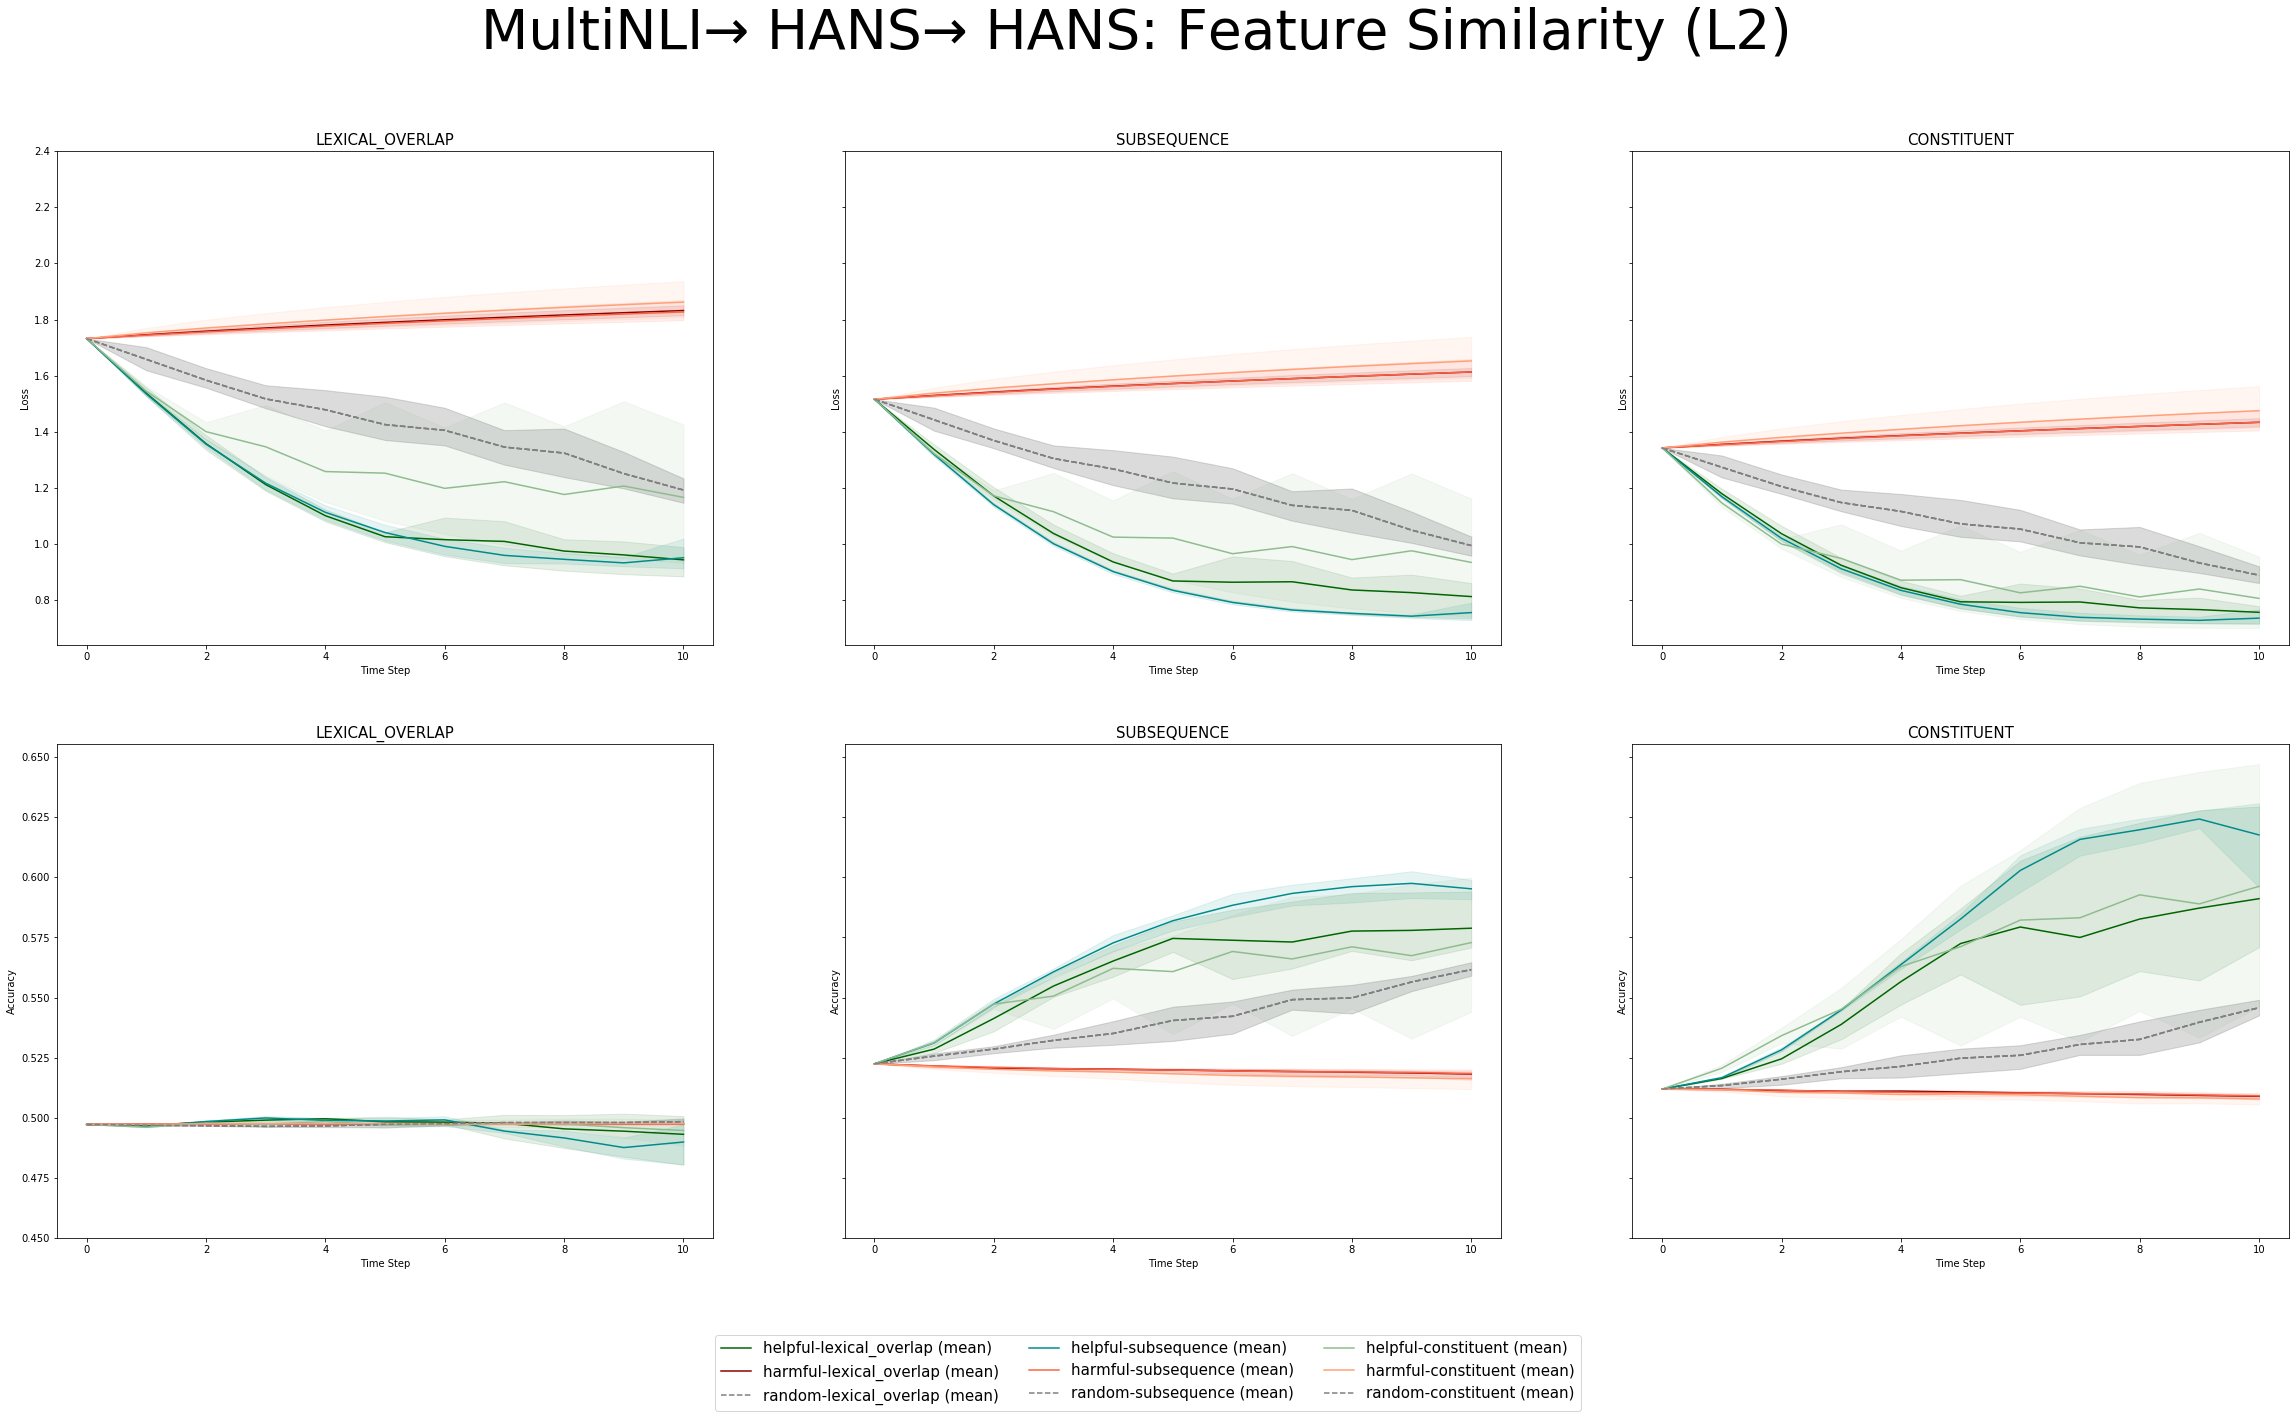

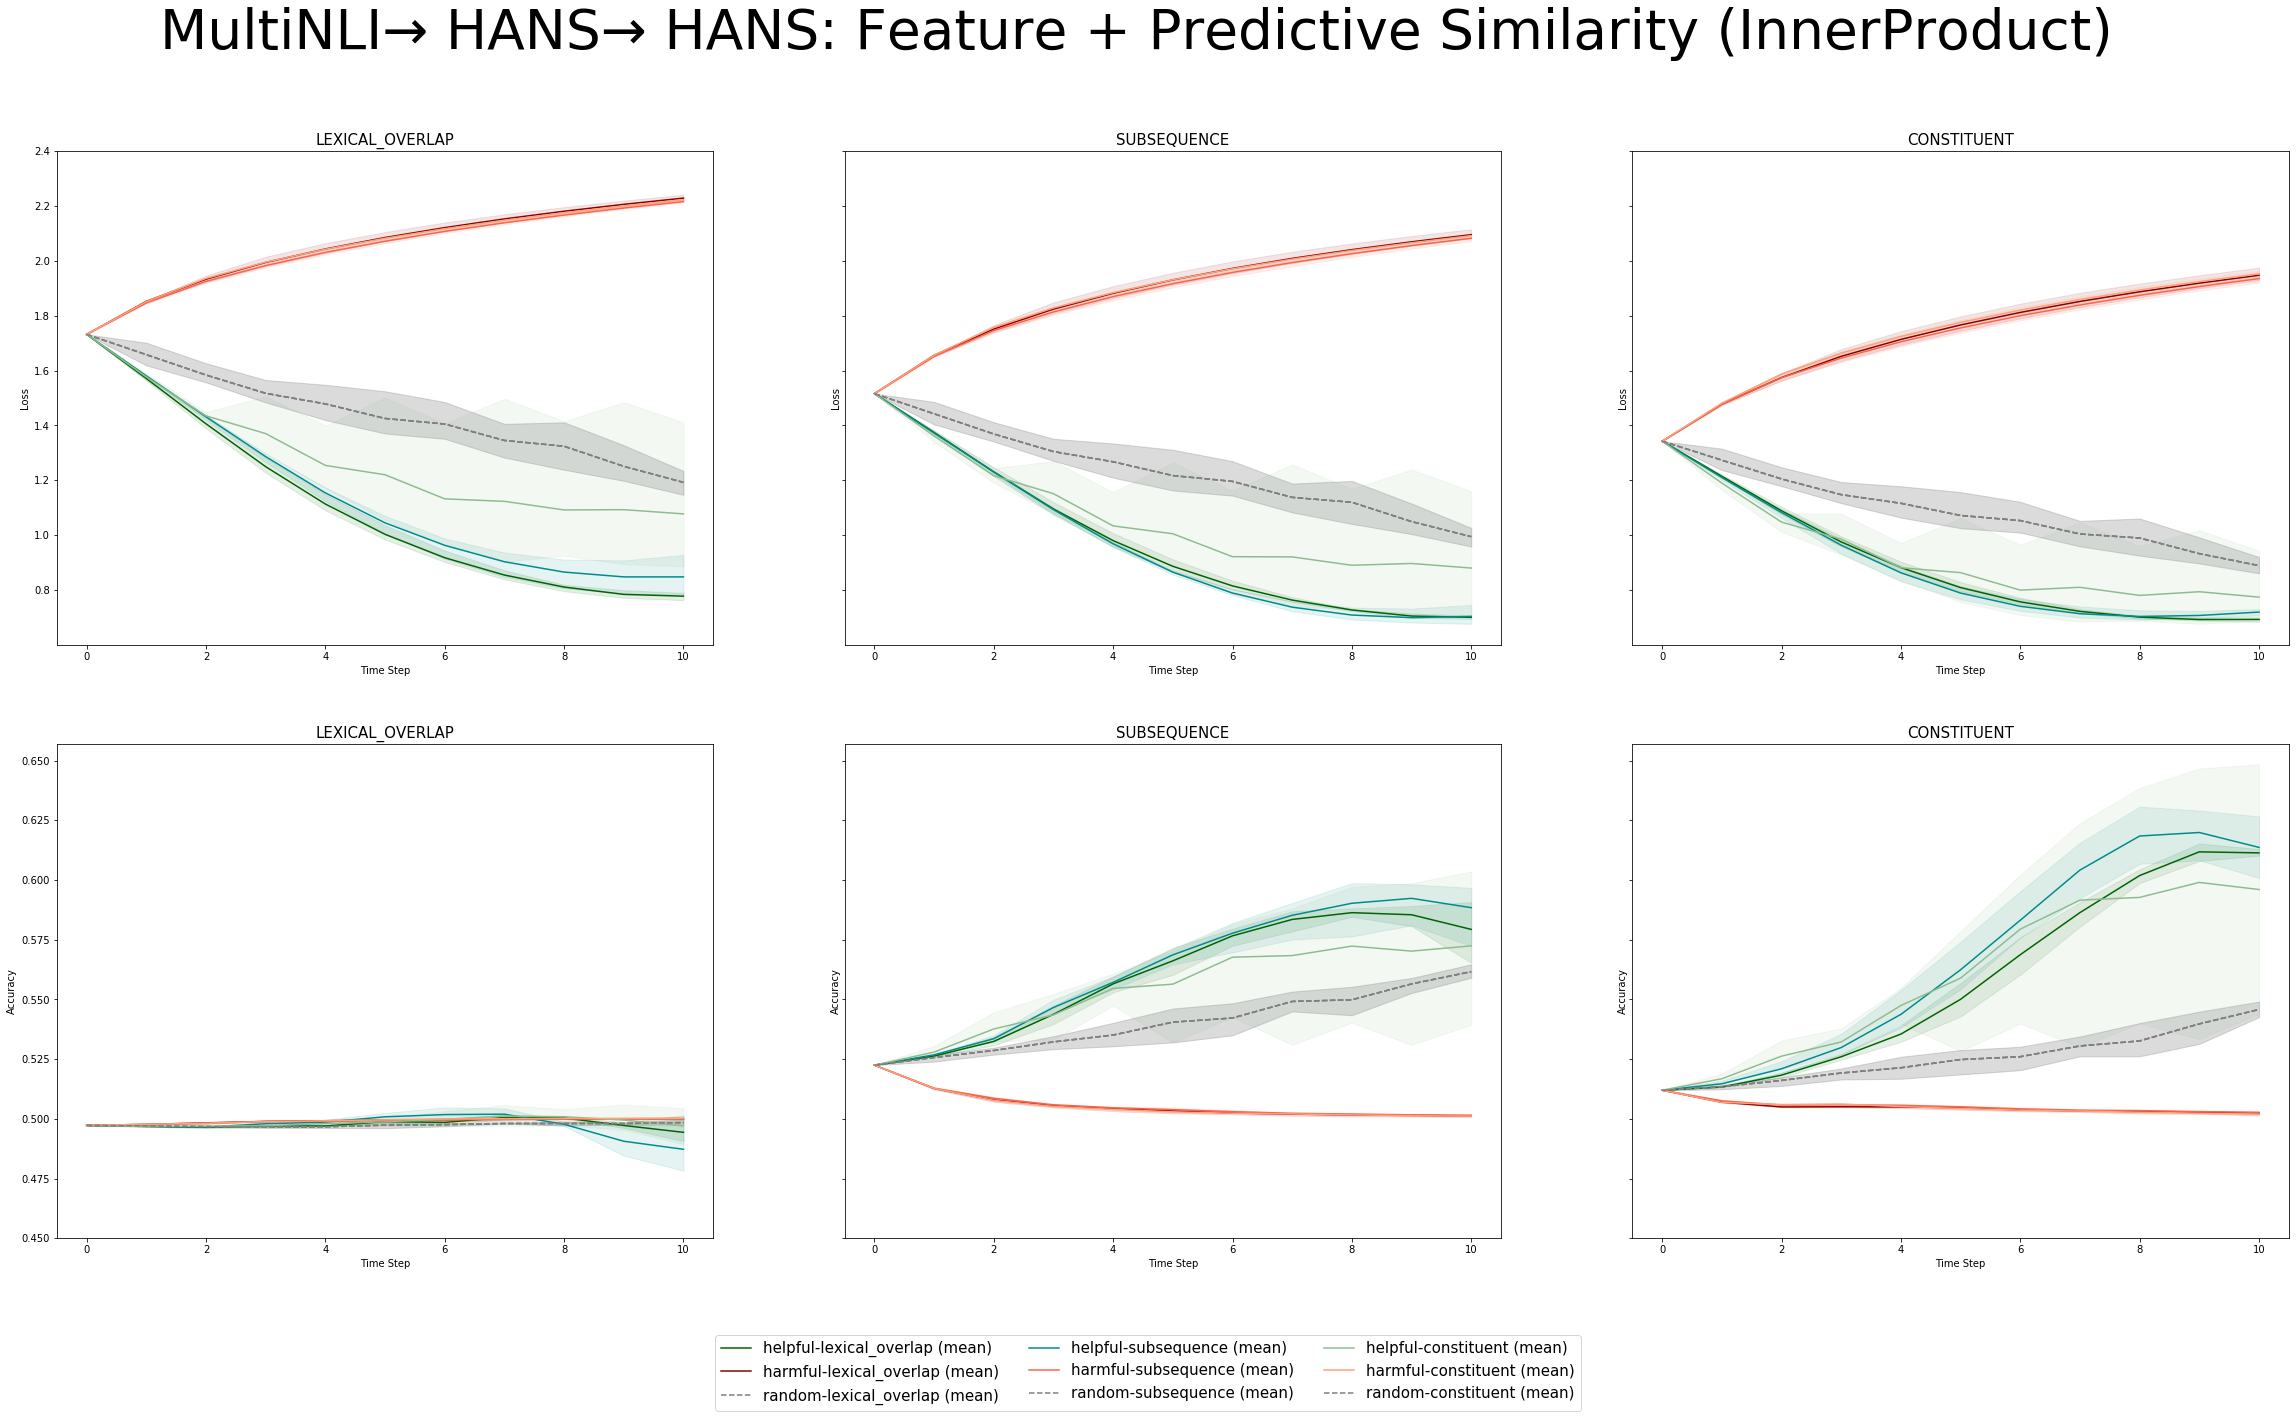

In [2]:
import torch
import self_code
l = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.hans.lexical_overlap.3.False_feature.pth"))
s = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.hans.subsequence.3.False_feature.pth"))
c = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.hans.constituent.3.False_feature.pth"))

lsc_data = {"lexical_overlap": l, "subsequence": s, "constituent":c}
fig = self_code.error_correction_viz(lsc_data, 'MultiNLI→ HANS→ HANS: Feature Similarity (L2)')
fig.savefig('Hans_Augmentation(HANS)_Feature_Similarity_L2.svg', dpi=200)

l = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.hans.lexical_overlap.3.False_pred_feature.pth"))
s = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.hans.subsequence.3.False_pred_feature.pth"))
c = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.hans.constituent.3.False_pred_feature.pth"))

lsc_data = {"lexical_overlap": l, "subsequence": s, "constituent":c}
fig = self_code.error_correction_viz(lsc_data, 'MultiNLI→ HANS→ HANS: Feature + Predictive Similarity (InnerProduct)')
fig.savefig('Hans_Augmentation(HANS)_Feature_Predictive_Similarity_InnerProduct.svg', dpi=200)

When using predictive features:
- Harmful datapoints reduce the overall model performance faster/more
- Mixed results for helpful datapoints: 
  - Better performance (reaching lower losses faster) for lexical_overlap
  - Worse performance for subsequence and constituent

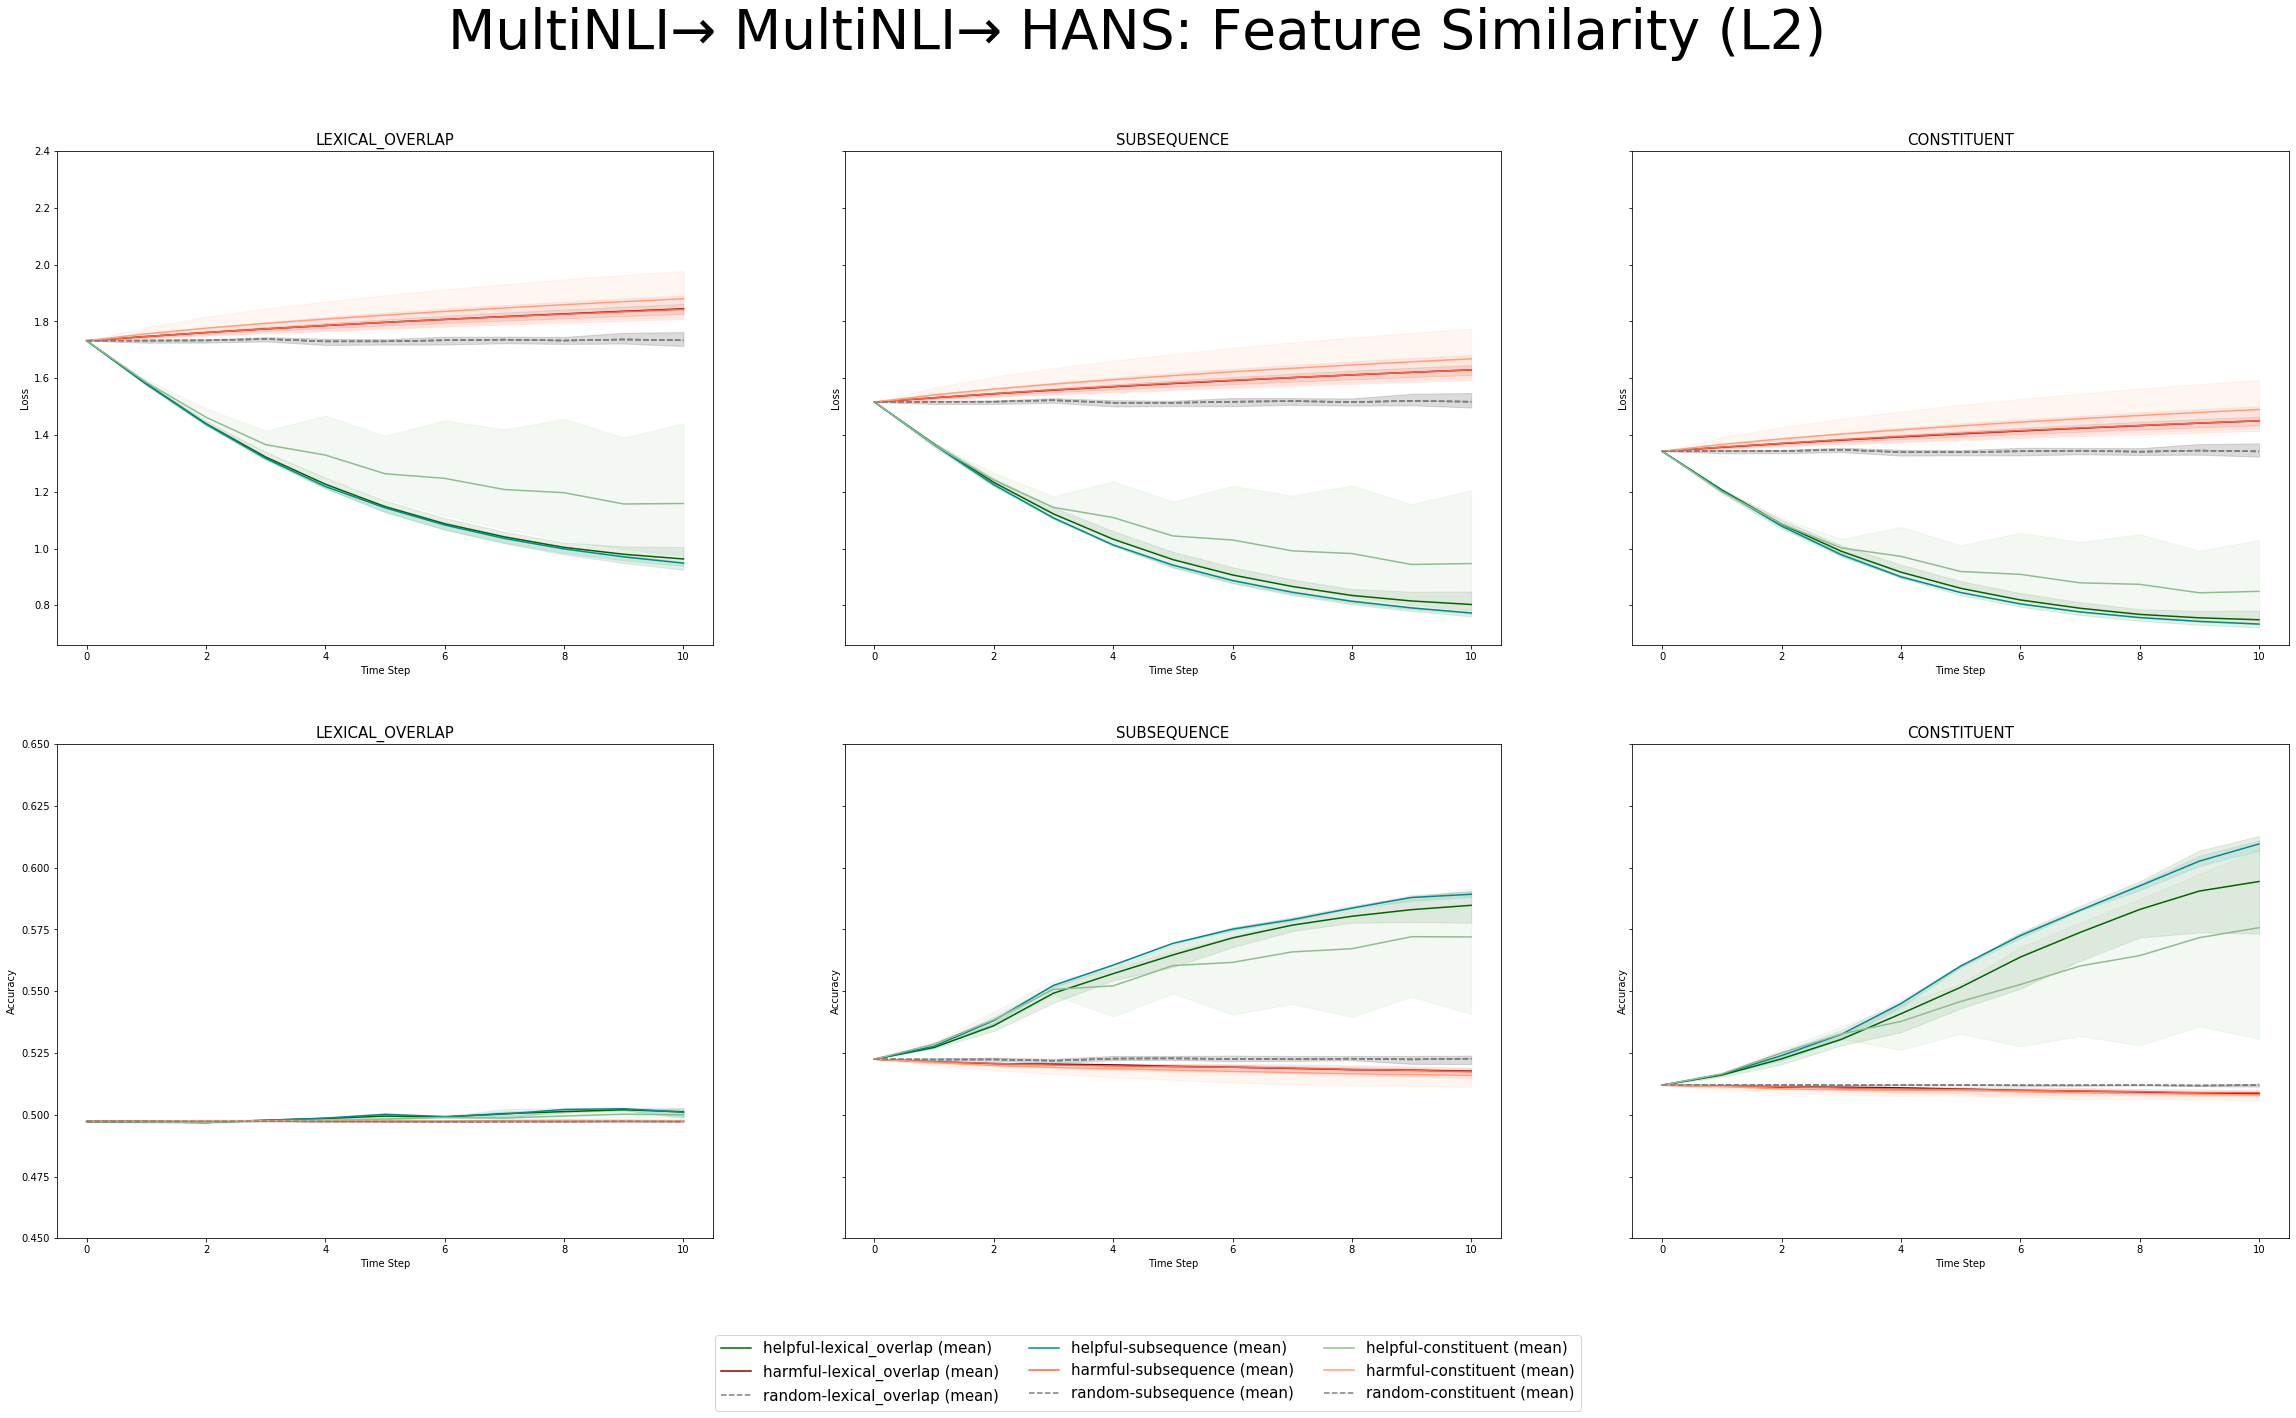

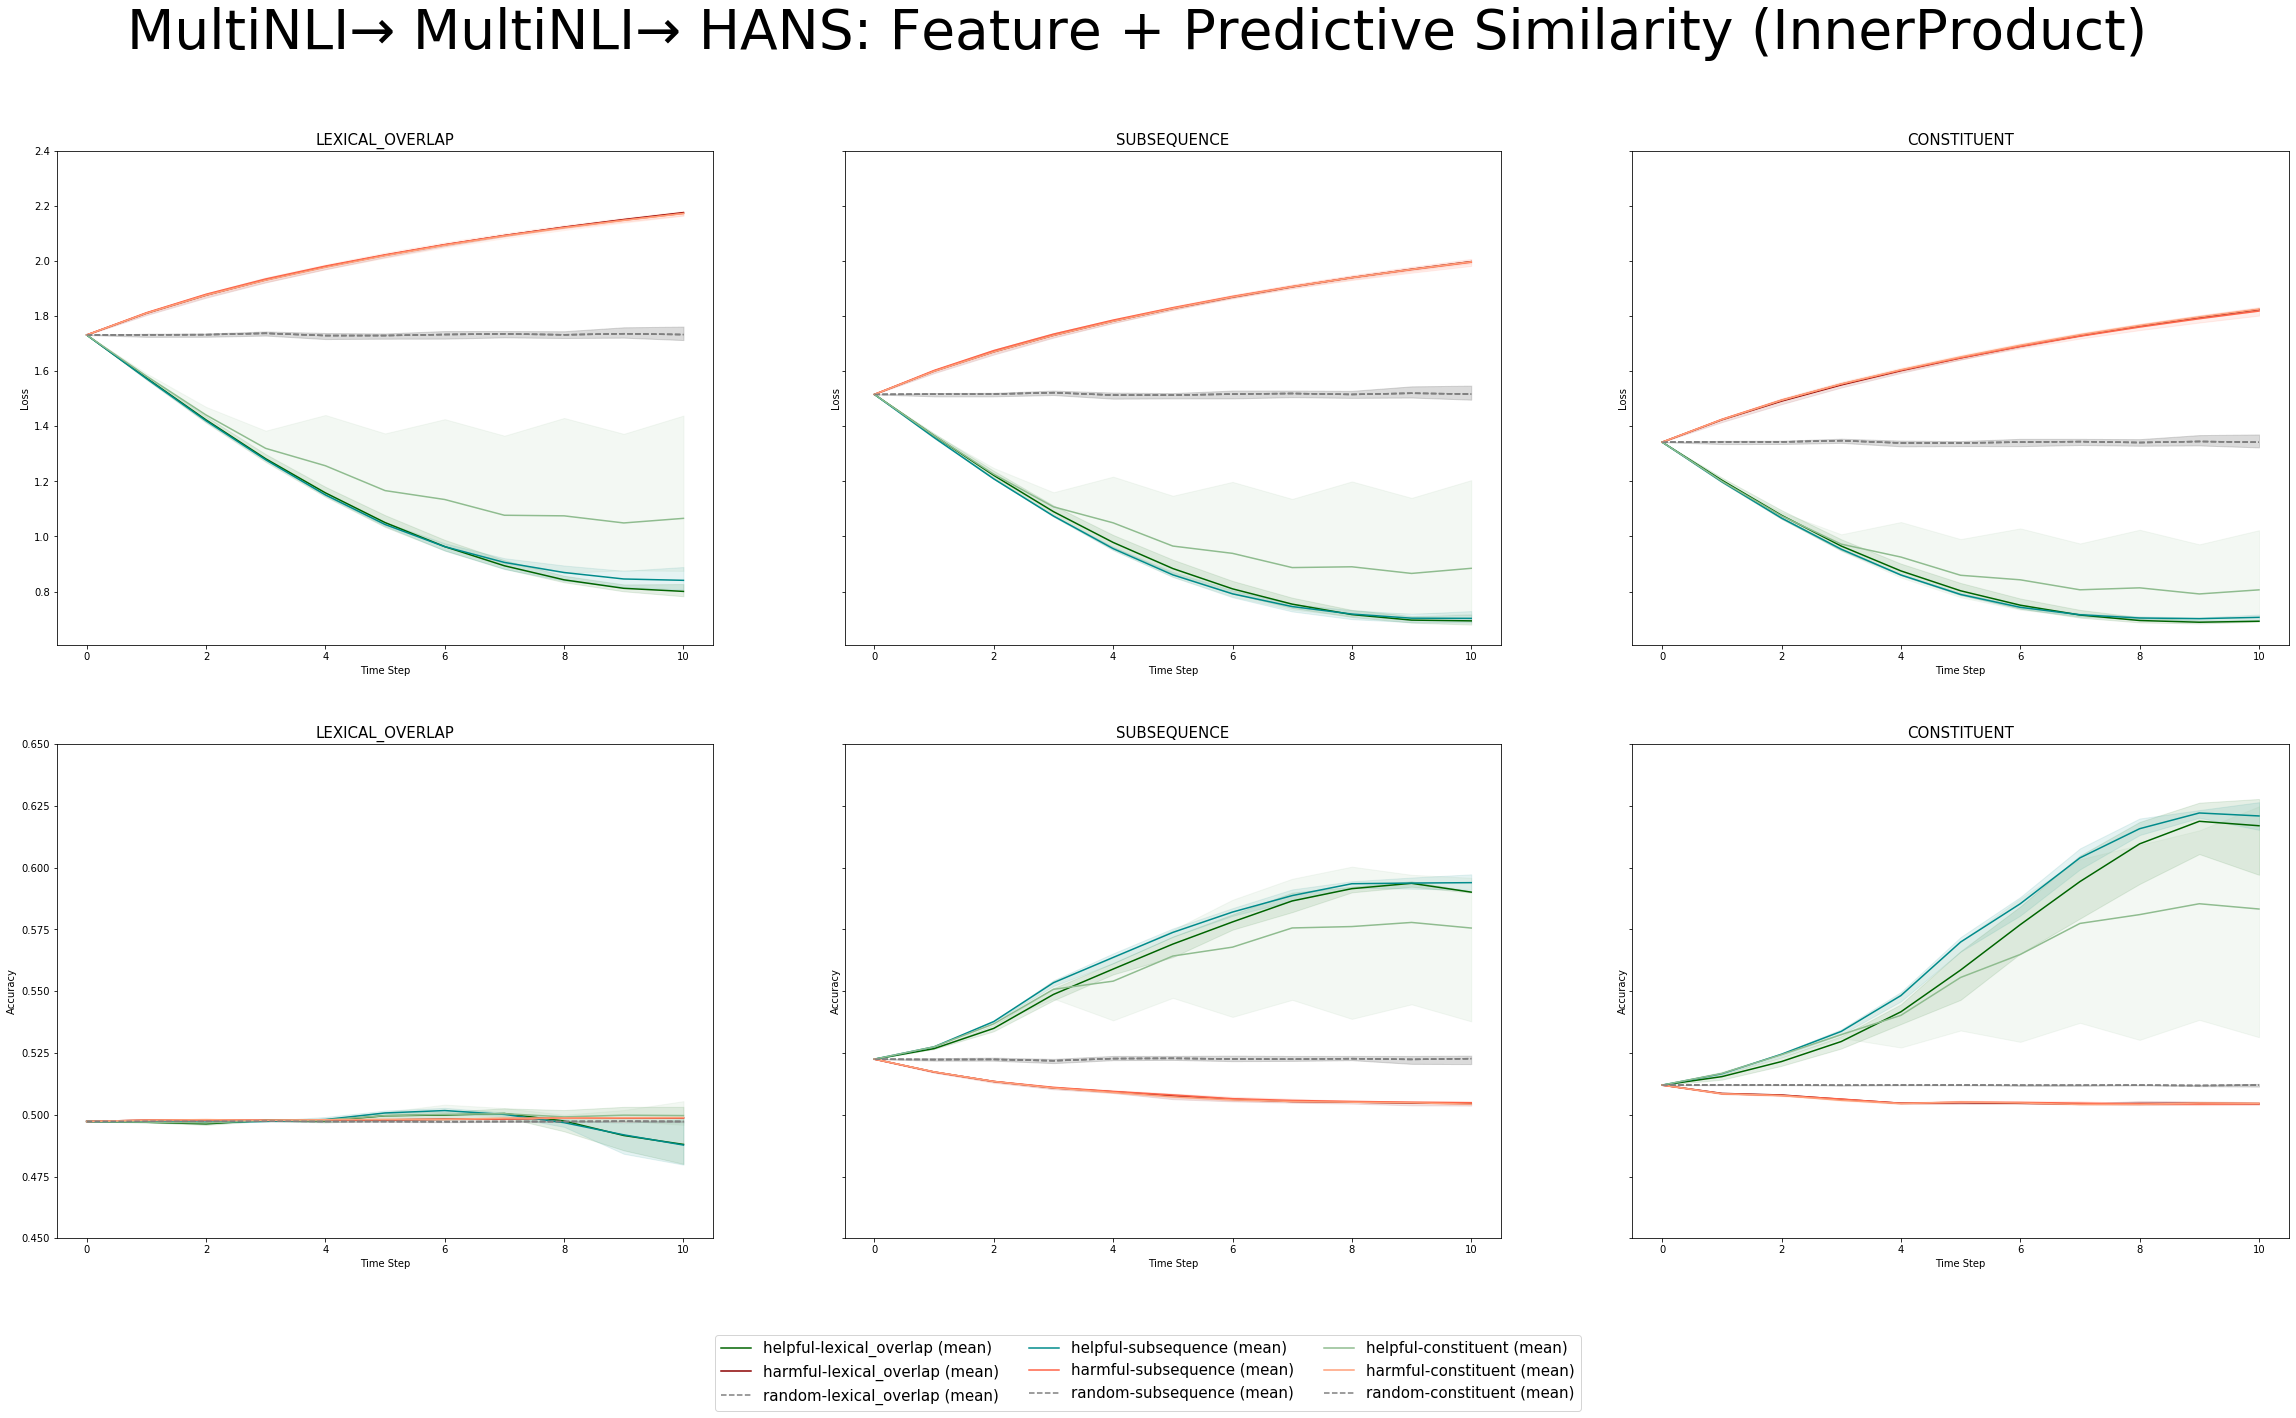

In [3]:
import torch
l = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.mnli-2.lexical_overlap.3.False_feature.pth"))
s = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.mnli-2.subsequence.3.False_feature.pth"))
c = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.mnli-2.constituent.3.False_feature.pth"))

lsc_data = {"lexical_overlap": l, "subsequence": s, "constituent":c}
fig = self_code.error_correction_viz(lsc_data, 'MultiNLI→ MultiNLI→ HANS: Feature Similarity (L2)')
fig.savefig('Hans_Augmentation(MNLI)_Feature_Similarity_L2.svg', dpi=200)

l = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.mnli-2.lexical_overlap.3.False_pred_feature.pth"))
s = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.mnli-2.subsequence.3.False_pred_feature.pth"))
c = to_dict(torch.load("experiments_outputs/hans_augmentation/z/hans-augmentation-new-only-z.mnli-2.constituent.3.False_pred_feature.pth"))

lsc_data = {"lexical_overlap": l, "subsequence": s, "constituent":c}
fig = self_code.error_correction_viz(lsc_data, 'MultiNLI→ MultiNLI→ HANS: Feature + Predictive Similarity (InnerProduct)')
fig.savefig('Hans_Augmentation(MNLI)_Feature_Predictive_Similarity_InnerProduct.svg', dpi=200)

When using predictive features:
- Better overall model performance